In [9]:
import numpy as np
import matplotlib.pyplot as pl
import everest
from everest.math import SavGol
from intrapix import PixelFlux,Polynomial
from random import randint
from astropy.io import fits
import pyfits
from everest import Transit
import k2plr
from k2plr.config import KPLR_ROOT
from everest.config import KEPPRF_DIR
import os
from scipy.optimize import fmin_powell

%matplotlib inline

In [10]:
# generate transit model

fpix = np.zeros((1000,5,5))

t = np.linspace(0,90,len(fpix))
per = 15
dur = 0.5
depth = 0.01
trn = Transit(t, t0 = 5.0, per = per, dur = dur, depth = depth)

(0.0, 90.0, 0.98499999999999999, 1.0049999999999999)

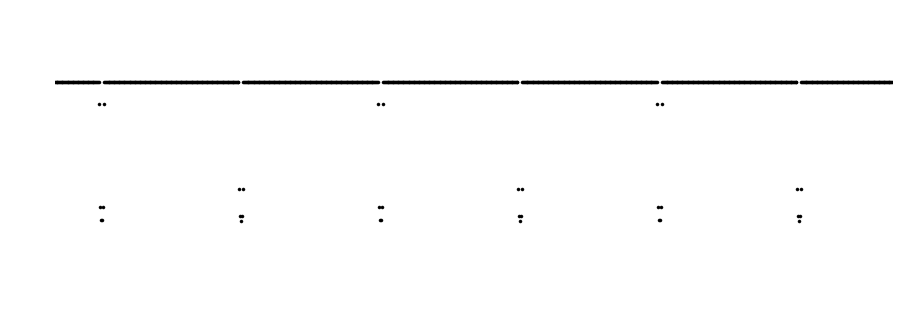

In [11]:
pl.figure(figsize=(15,5));
pl.plot(t,trn,'k.')
pl.axis((0,90,0.985,1.005));
pl.xlabel('Time (days)'); pl.ylabel('Flux (counts)');
pl.axis('off');
# pl.savefig('transit.eps', format='eps', dpi=250)

In [12]:
#read in relevant data

ID = 205998445
client = k2plr.API()
star = client.k2_star(ID)
tpf = star.get_target_pixel_files(fetch = True)[0]
ftpf = os.path.join(KPLR_ROOT, 'data', 'k2', 'target_pixel_files', '%d' % ID, tpf._filename)
with pyfits.open(ftpf) as f:
    xpos = f[1].data['pos_corr1']
    ypos = f[1].data['pos_corr2']

In [13]:
# throw out outliers and limit to first 1000 cadences

for i in range(len(xpos)):
    if abs(xpos[i]) >= 50 or abs(ypos[i]) >= 50:
        xpos[i] = 0
        ypos[i] = 0
    if np.isnan(xpos[i]):
        xpos[i] = 0
    if np.isnan(ypos[i]):
        ypos[i] = 0
    '''
    else:
        xpos[i] /= 5
        ypos[i] /= 5
        
    '''
    
xpos = xpos[:1000]
ypos = ypos[:1000]


In [14]:
# define intra-pixel sensitivity variation

intra = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        intra[i][j] = (0.995 + np.random.randint(10) / 1000)

In [15]:
# mask transits
naninds = np.where(trn < 1)
M = lambda x: np.delete(x, naninds, axis = 0)

In [16]:
# generate PSF model with inter-pixel sensitivity variation

cx = [1.0,0.0,-.2]
cy = [1.0,0.0,-.2]
amp = [355000.0]
x0 = 2.5
y0 = 2.5
sx = [.5]
sy = [.5]
rho = [0]

magdiff = 1.0
r = 10**(magdiff / 2.5)

target = np.zeros((len(fpix),5,5))
ferr = np.zeros((len(fpix),5,5))
background_level = 800

for c in range(1000):
    for i in range(5):
        for j in range(5):

            # contribution from target
            target_val = trn[c]*PixelFlux(cx,cy,amp,[x0-i+xpos[c]],[y0-j+ypos[c]],sx,sy,rho)
            
            # contribution from neighbor
            val = target_val + (1/r)*PixelFlux(cx,cy,amp,[4.-i+xpos[c]],[4.-j+ypos[c]],sx,sy,rho)
            
            target[c][i][j] = target_val
            fpix[c][i][j] = val
            
            # add photon noise
            ferr[c][i][j] = np.sqrt(fpix[c][i][j]) 
            randnum = np.random.randn()
            fpix[c][i][j] += ferr[c][i][j] * randnum
            target[c][i][j] += ferr[c][i][j] * randnum
            
            # add background noise
            noise = np.sqrt(background_level) * np.random.randn()
            fpix[c][i][j] += background_level + noise
            target[c][i][j] += background_level + noise
            
    # multiply by intra-pixel variation
    fpix[c] *= intra
    target[c] *= intra

(0.0, 90.0, 420000.0, 455000.0)

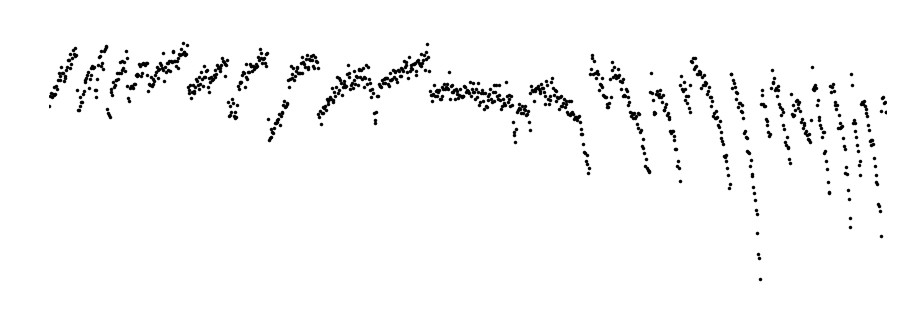

In [17]:
raw_fpix_rs = fpix.reshape(len(fpix),-1)
raw_flux = np.sum(raw_fpix_rs,axis=1)

pl.figure(figsize=(15,5))
# pl.plot(t,trn*np.mean(raw_flux),'r');
pl.plot(t,raw_flux,'k.');
# pl.xlabel('Time (days)'); pl.ylabel('Flux (counts)');
pl.axis('off');
# pl.savefig('nomotion_transit.eps', format='eps', dpi=250, transparent=True)

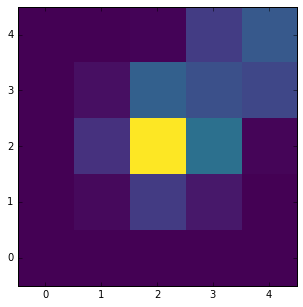

In [18]:
fig = pl.figure(figsize=(5.6,5));
pl.imshow(fpix[-1],interpolation='nearest',origin='lower',cmap='viridis');
# pl.savefig('neighbor.eps', format='eps', dpi=250, transparent=True)

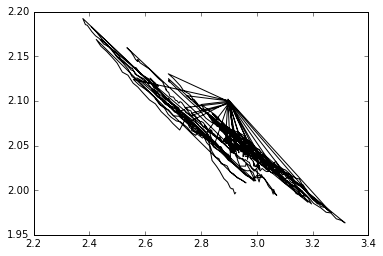

In [19]:
def CenterOfFlux(fpix):
    ncad, ny, nx = fpix.shape
    x0 = np.zeros(ncad)
    y0 = np.zeros(ncad)
    for n in range(ncad):
        x0[n] = np.sum([(i+0.5)*fpix[n][:,i] for i in range(nx)]) / np.sum(fpix[n])
        y0[n] = np.sum([(ny-j-0.5)*fpix[n][j,:] for j in range(ny)]) / np.sum(fpix[n])
    return x0,y0

x0,y0 = CenterOfFlux(fpix)
pl.plot(x0,y0,'k')

In [20]:
def crowding(fpix):
    # crowding parameter for each pixel
    c_pix = np.zeros((len(fpix),5,5))

    # crowding parameter for entire detector
    c_det = np.zeros((len(fpix)))

    for c in range(len(fpix)):
        for i in range(5):
            for j in range(5):
                if np.isnan(fpix[c][i][j]):
                    continue
                else:
                    c_pix[c][i][j] = target[c][i][j] / fpix[c][i][j]

        c_det[c] = np.nansum(target[c]) / np.nansum(fpix[c])
        
    return c_det, c_pix

c_det, c_pix = crowding(fpix)

In [21]:
def firstOrderPLD(fpix):
    
    fpix_rs = fpix.reshape(len(fpix),-1)
    flux = np.sum(fpix_rs,axis=1)

    # mask transits
    X = fpix_rs / flux.reshape(-1,1)
    MX = M(fpix_rs) / M(flux).reshape(-1,1)

    # perform first order PLD
    A = np.dot(MX.T, MX)
    B = np.dot(MX.T, M(flux))
    C = np.linalg.solve(A, B)

    # compute detrended light curve
    model = np.dot(X, C)
    detrended = flux - model + np.nanmean(flux)

    D = (detrended - np.dot(C[1:], X[:,1:].T) + np.nanmedian(detrended)) / np.nanmedian(detrended)
    T = (t - 5.0 - per / 2.) % per - per / 2.
    
    return detrended, flux

detrended, flux = firstOrderPLD(fpix)

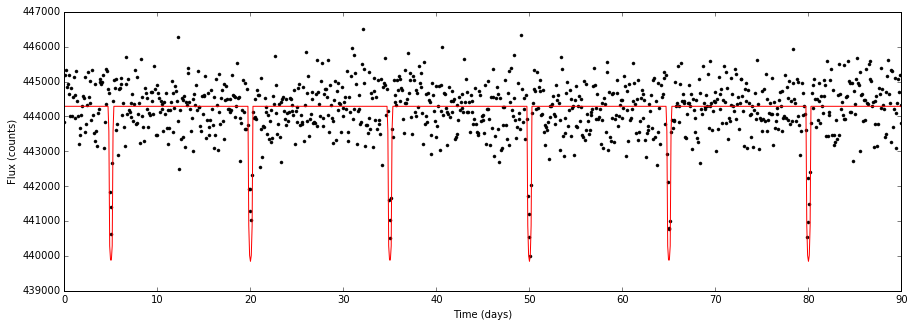

In [22]:
pl.figure(figsize=(15,5))
pl.plot(t,detrended,'k.');
pl.plot(t,np.mean(flux)*trn,'r');
pl.xlabel('Time (days)'); pl.ylabel('Flux (counts)');

In [ ]:
def recoverTransit(lightcurve_in):
    '''
    Solve for depth of transit in detrended lightcurve
    '''

    detrended = lightcurve_in
    
    # normalize transit model
    transit_model = (trn - 1) / depth

    # create relevant arrays
    X = np.array(([],[]), dtype = float).T
    for i in range(len(fpix)):
        rowx = np.array([[1.,transit_model[i]]])
        X = np.vstack((X, rowx))
    Y = detrended / np.nanmedian(detrended)

    # solve for recovered transit depth
    A = np.dot(X.T, X)
    B = np.dot(X.T, Y)
    C = np.linalg.solve(A, B)
    rec_depth = C[1]

    return rec_depth

rd_noap = recoverTransit(detrended)

In [ ]:
# define aperture
aperture1 = np.zeros((5,5))
aperture2 = np.zeros((5,5))

for i in range(5):
    for j in range(5):
        if i == 3 and j == 3:
            aperture1[i][j] = 1.0
            aperture2[i][j] = np.nan
        elif -1 < i < 4 and -1 < j < 4:
            aperture1[i][j] = 1.0
            aperture2[i][j] = 1.0
        else:
            aperture1[i][j] = np.nan
            aperture2[i][j] = np.nan

In [ ]:
def aperturePLD(fpix, aperture):
    
    aperture = [aperture for i in range(len(fpix))]
                    
    # import pdb; pdb.set_trace()
    fpix_rs = (fpix*aperture).reshape(len(fpix),-1)
    fpix_ap = np.zeros((len(fpix),len(np.delete(fpix_rs[0],np.where(np.isnan(fpix_rs[0]))))))
    
    for c in range(len(fpix_rs)):
        naninds = np.where(np.isnan(fpix_rs[c]))
        fpix_ap[c] = np.delete(fpix_rs[c],naninds)
     
    flux = np.sum(fpix_ap,axis=1)
    X = fpix_ap / flux.reshape(-1,1)
    MX = M(fpix_ap) / M(flux).reshape(-1,1)
    
    # perform first order PLD
    A = np.dot(MX.T, MX)
    B = np.dot(MX.T, M(flux))
    C = np.linalg.solve(A, B)

    # compute detrended light curve
    model = np.dot(X, C)
    detrended = flux - model + np.nanmean(flux)
                    
    return aperture,detrended,flux

In [ ]:
ap1, apdetrended1, apflux1 = aperturePLD(fpix,aperture1)
ap2, apdetrended2, apflux2 = aperturePLD(fpix,aperture2)
pl.figure(figsize=(15,5))
pl.plot(t,apdetrended2,'k.');
pl.plot(t,np.mean(apflux2)*trn,'r');
pl.xlabel('Time (days)'); pl.ylabel('Flux (counts)');
# pl.savefig('lightcurve1.eps', format='eps', dpi=250)

In [ ]:
dc0, pc0 = crowding(fpix)
dc1, pc1 = crowding(fpix*aperture1)
dc2, pc2 = crowding(fpix*aperture2)
rd_ap1 = recoverTransit(apdetrended1)
rd_ap2 = recoverTransit(apdetrended2)
np.mean(dc0)

In [ ]:
fig, ax = pl.subplots(1,3, sharey=True)
fig.set_size_inches(17,5)

ax[0].imshow(fpix[-1],interpolation='nearest',origin='lower',cmap='viridis')
ax[1].imshow(ap1[-1]*fpix[-1],interpolation='nearest',origin='lower',cmap='viridis')
ax[2].imshow(ap2[-1]*fpix[-1],interpolation='nearest',origin='lower',cmap='viridis')
'''
ax[0].annotate(r'$\mathrm{Recovered\ Depth}: %.4f$' % (rd_noap),
                xy = (0.05, 0.05),xycoords='axes fraction',
                color='w', fontsize=12);
ax[1].annotate(r'$\mathrm{Recovered\ Depth}: %.4f$' % (rd_ap1),
                xy = (0.05, 0.05),xycoords='axes fraction',
                color='w', fontsize=12);
ax[2].annotate(r'$\mathrm{Recovered\ Depth}: %.4f$' % (rd_ap2),
                xy = (0.05, 0.05),xycoords='axes fraction',
                color='w', fontsize=12);

ax[0].annotate(r'$\mathrm{Crowding\ Corrected\ Depth}: %.4f$' % (rd_noap / np.mean(dc0)),
                xy = (0.05, 0.05),xycoords='axes fraction',
                color='w', fontsize=12);
ax[1].annotate(r'$\mathrm{Crowding\ Corrected\ Depth}: %.4f$' % (rd_ap1 / np.mean(dc1)),
                xy = (0.05, 0.05),xycoords='axes fraction',
                color='w', fontsize=12);
ax[2].annotate(r'$\mathrm{Crowding\ Corrected\ Depth}: %.4f$' % (rd_ap2 / np.mean(dc2)),
                xy = (0.05, 0.05),xycoords='axes fraction',
                color='w', fontsize=12);
'''
# pl.savefig('aps.eps', format='eps', dpi=250,transparent=True)

In [ ]:
def PSF(params):
    amp1,amp2,x01,x02,y01,y02 = params
    
    cx_1 = [1.,0.,0.]
    cx_2 = [1.,0.,0.]
    cy_1 = [1.,0.,0.]
    cy_2 = [1.,0.,0.]
    sx = 0.5
    sy = 0.5
    rho = 0.0
    
    
    model = np.zeros((5,5))
    for i in range(5):
        for j in range(5):
            model[i][j] = PixelFlux(cx_1, cy_1, [amp1], [x01-i], [y01-j], [sx], [sy], [rho]) + \
                          PixelFlux(cx_2, cy_2, [amp2], [x02-i], [y02-j], [sx], [sy], [rho])
    return model

In [ ]:
# fit PSF for target and neighbor simultaneously

nsrc = 2
xtol = 0.0001
ftol = 0.0001

def FindSolution(index = 100):
    
    X = np.nansum((fpix[index] / ferr[index]) ** 2)
    
    amp = [355000.0,(355000.0 / r)]
    x0 = [2.5,4.]
    y0 = [2.5,4.]
    sx = [.5]
    sy = [.5]
    rho = [0]

    guess = np.concatenate([amp,x0,y0])
    
    answer, chisq, _, iter, funcalls, warn = fmin_powell(LnLikelihood, guess, xtol = xtol, ftol = ftol,
                                                         disp = False, full_output = True)

    bic = chisq + len(answer) * np.log(len(fpix))
    
    return bic, chisq, answer
    

In [ ]:
def Fit(params):
    '''
    Returns a simple :py:class:`Fit` object that
    contains information about the PSF fit.

    '''

    # read variables
    amp1,amp2,x01,x02,y01,y02 = params
    
    fit = PSF(params)

    # instance the class
    return type('Fit', (object,), {'amp1' : amp1, 'amp2' : amp2, 'x01' : x01, 'x02' : x02, 'y01' : y01, 'y02' : y02, 
                                   'fit': fit})

In [ ]:
def LnLikelihood(params):
    
    fit = Fit(params)
    PSFfit = fit.fit
    index = 100
    dtol = 0.01
    x01 = fit.x01
    y01 = fit.y01
    x02 = fit.x02
    y02 = fit.x02
    
    # sum squared difference between data and model 
    PSFres = np.nansum(((fpix[index] - PSFfit) / ferr[index]) ** 2)
    
    '''
    PSFres += np.nansum(((np.array([2.5,4.]) - np.array([x01,x02])) / dtol) ** 2 + \
                        ((np.array([2.5,4.]) - np.array([y01,y02])) / dtol) ** 2)
    if max(np.abs(2.5 - x01), np.abs(2.5 - y01)) > 10.0:
    PRFres = 1.0e300
    
    
    # Prior likelihood
    s_s = 1.
    sx0 = 0.5 + s_s * np.random.randn()
    sy0 = 0.5 + s_s * np.random.randn()
    PSFres += (1/2) * ((sx - sx0) / s_s)**2
    PSFres += (1/2) * ((sy - sy0) / s_s)**2
    PSFres += (-1/2) * (rho / s_s)**2
    '''
    
    # constrain position values
    if ((2.5 - x01)**2 + (2.5 - y01)**2) > 16:
        PSFres = 1.0e300  
    if ((4. - x02)**2 + (4. - y02)**2) > 16:
        PSFres = 1.0e300 
    if rho > 1 or rho < -1:
        PSFRes = 1.0e300
        
    #if (sx > 2 * np.pi) or (sy > 2 * np.pi):
    #    PSFres = 1.0e300 
 
    # Reject negative values
    for elem in params:
        if elem < 0:
            PSFres = 1.0e300

    return PSFres

In [ ]:
bic,quisq,answer = FindSolution()

In [ ]:
amp = [355000.0,(355000.0 / r)]
x0 = [2.5,4.]
y0 = [2.5,4.]
sx = [.5]
sy = [.5]
rho = [0]

guess = np.concatenate([amp,x0,y0])

tryPSF = PSF(answer)
realPSF = PSF(guess)
pl.imshow(tryPSF,interpolation='nearest',origin='lower',cmap='viridis')

In [ ]:
pol = lambda x: Polynomial(x,[1.,0.,-0.05])
x = np.linspace(-0.5,0.5,100)
pl.plot(x,pol(x))

In [ ]:
fig = pl.figure(figsize=(5.6,5));
pl.imshow(c_pix[-1],interpolation='nearest',origin='lower',cmap='jet_r');pl.colorbar();
# pl.savefig('crowding.eps', format='eps', dpi=250, transparent=True)

In [ ]:
t1 = np.linspace(0,90,10000)
trn1 = Transit(t1, t0 = 5.0, per = per, dur = dur, depth = depth)
pl.figure(figsize=(22,5));
pl.plot(t1,trn1,'k.');
pl.xlim([0,40]);
pl.ylim([0.987,1.001]);
pl.axis('off');
# pl.savefig('perftransit.eps', format='eps', dpi=250, transparent=True);

In [ ]:
import matplotlib.animation as animation

fig2 = pl.figure()

x = np.arange(-9, 10)
y = np.arange(-9, 10).reshape(-1, 1)
base = np.hypot(x, y)
ims = []
for add in np.arange(15):
    ims.append((pl.pcolor(x, y, base + add, norm=pl.Normalize(0, 30)),))

im_ani = animation.ArtistAnimation(fig2, ims, interval=50, repeat_delay=3000,
                                   blit=True)
# To save this second animation with some metadata, use the following command:
# im_ani.save('im.mp4', metadata={'artist':'Guido'})

pl.show()

In [ ]:
fig = pl.figure(figsize=(5.6,5))
answer_neighbor = [0,(355000.0),0,3.5,0,3.5]
neighborPSF = PSF(answer_neighbor)
PSFModel = PSF([355000.0,(355000.0),2.5,3.5,2.5,3.5])
pl.imshow(PSFModel,interpolation='nearest',origin='lower',cmap='viridis')
pl.savefig('brightneigh.eps', format='eps', dpi=250, transparent=True)

In [ ]:
fitout = PSFModel-neighborPSF
pl.imshow(fitout,interpolation='nearest',origin='lower',cmap='viridis');pl.colorbar()

In [ ]:
fig, ax = pl.subplots(1,3, sharey=True)
fig.set_size_inches(17,5)

ax[0].imshow(PSFModel,interpolation='nearest',origin='lower',cmap='viridis',vmin=0,vmax=160000)
ax[1].imshow(neighborPSF,interpolation='nearest',origin='lower',cmap='viridis',vmin=0,vmax=160000)
ax[2].imshow(fitout,interpolation='nearest',origin='lower',cmap='viridis',vmin=0,vmax=160000)
pl.savefig('fittest.eps', format='eps', dpi=250,transparent=True)

In [ ]:
answer - guess